## <span style="color:olivedrab"> Exercise 07: Metropolis Simulation of a LJ model of Argon </span>

In [1]:
#import essential libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#parameter to use Latex in matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
#a plot label should be easy to read
plt.rcParams.update({'font.size': 14})

This exercise is a reprise of exercise 4: we will perform Monte-Carlo simulations (instead of molecular dynamics simulations) of Argon modellized via a Lennard-Jones potential: 
$$
V_\mathrm{LJ}(r)=4\epsilon \left[\left(\frac{\sigma}{r} \right)^{12} - \left(\frac{\sigma}{r} \right)^6 \right]
$$

This time we are in the $\textbf{canonical ensemble}$, where temperature is inherently kept constant by the MC algorithm.

We will:
1. implement tail corrections for pressure and potential energy throught the idea $g(r)\approx 1$ at radius greater than $r_c$
2. study the relevance of equilibration steps, correlation between steps and the subsequent underestimation of the statistical error
3. inspect the pair distribution function $g(r)$ and other important quantities for different phases of Argon

### <span style="color:olivedrab"> 04.1: Equilibration and Step Size</span>

First of all, our simulations should respect the rule of thumb stating that the acceptance shall be $50%$. In order to do so we tweak the width of the uniform transition kernel:
| phase |  stepsize | acceptance |
| :-: | :-: | :-: | 
| Solid | 0.11 | 0.5|
| Liquid  | 0.2 | 0.5|
| Gas | 6 | 0.62|

Gas simulation generically has a greater acceptance for a wide range of widths, so we are satisfied with $\approx 0.6$.

Then we look at $\frac{U^*}{N}$ to understand how many steps are needed to equilibrate the simulation: compared to NVE simulations, here there is no need to modify the starting $T$ or build a heat bath to reach the desired temperature, yet some equilibration steps are needed, as in every Metropolis algorithm, to move from the starting config -which may be very atypical for the temperature one wishes to study- to representative ones.

The simulation was done with $2\times 10^5$ number of blocks, with $1$ step per block: we indeed need to look at istantaneous values, both here and in the few next analysis.

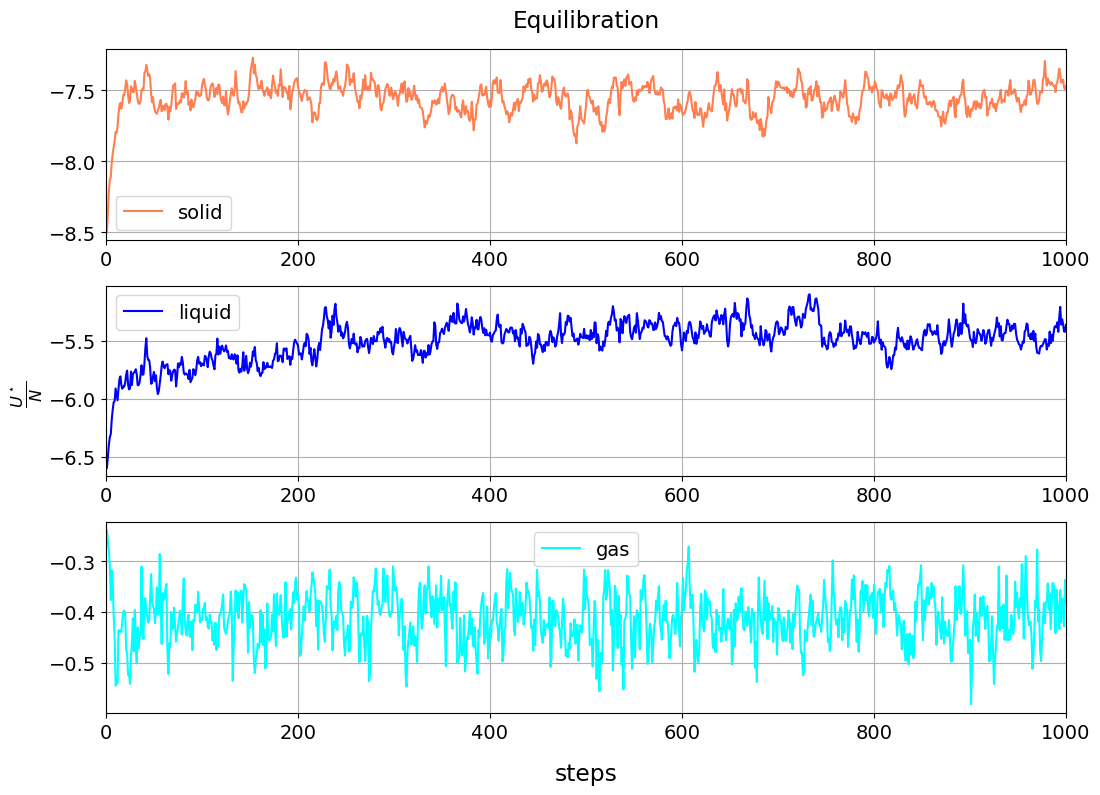

In [187]:
#U/N before thermalization

#import data formatted as table from a .txt file into a dictionary
thermalization_data = {
    'gas'    :  np.loadtxt('equilibration/gas_simulation/output_epot.dat'),
    'liquid' :  np.loadtxt('equilibration/liquid_simulation/output_epot.dat'),
    'solid'  :  np.loadtxt('equilibration/solid_simulation/output_epot.dat')
}

L=1                  # Block size

fig,ax = plt.subplots(3,1,figsize=(12,8))
axs = ax.flatten()
systems = ['solid','liquid','gas']
colors=['coral','blue','cyan']
T_target=[0.8,1.1,1.2]
#plot the temperatures
for i in range(3):
    axs[i].plot(thermalization_data[systems[i]][:1000,0]*L,thermalization_data[systems[i]][:1000,1], color=colors[i], label = systems[i])
    axs[i].grid(True)
    #axs[i].axhline(y=T_target[i], color= "black",linestyle='-.', label=fr'$T^\star = {T_target[i]}$')
    axs[i].legend()
    axs[i].set_xbound(0,len(thermalization_data[systems[i]][:1000,0]))
fig.suptitle("Equilibration")
fig.supxlabel('steps')
fig.supylabel(r"$\frac{U^\star}{N}$")
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.93, wspace=0.2, hspace=0.24)
plt.show()

Looking at the data plotted in a narrowed range for clarity, we can safely say that $500$ steps are sufficient for the equilibration. 

In [188]:
equilibrationSteps = 500

### <span style="color:olivedrab"> 04.2: Autocorrelation Function and Data Blocking </span>

Before the actual simulation, it is important to know how large should each block be.
We first evaluate the autocorrelation function from the previous data, after dropping the first $500$ points.

In [23]:
def autocorr(x,lags):
    '''fft, don't pad 0s, non partial'''
    mean=x.mean()
    var=np.var(x)
    xp=x-mean

    cf=np.fft.fft(xp)
    sf=cf.conjugate()*cf
    corr=np.fft.ifft(sf).real/var/len(x)

    return corr[:len(lags)]

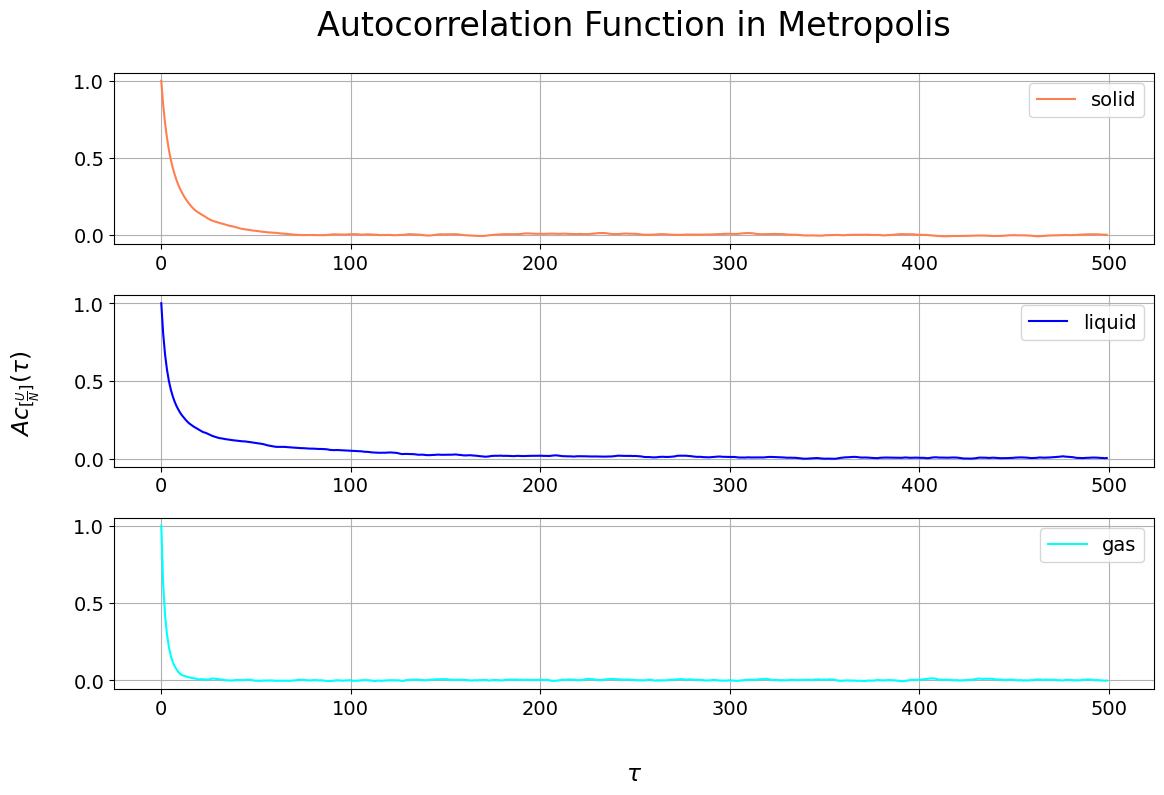

In [77]:
fig,ax = plt.subplots(3,1,figsize=(13,8))
axs = ax.flatten()

lag_range = 500

systems = ['solid','liquid','gas']
colors=['coral','blue','cyan']

udata = np.loadtxt('equilibration/gas_simulation/output_epot.dat')
acf0=autocorr(udata[equilibrationSteps:,1],range(lag_range))
lags=range(lag_range)
axs[2].plot(lags,acf0, color="cyan", label=r'gas')
axs[2].grid(True)
#axs[0].set_ylim(-0.0065,0.0065)
axs[2].legend()

udata = np.loadtxt('equilibration/liquid_simulation/output_epot.dat')
acf1=autocorr(udata[equilibrationSteps:,1],range(lag_range))
axs[1].plot(lags,acf1, color="blue", label=r'liquid')
axs[1].grid(True)
#axs[1].set_ylim(-0.001,0.001)
axs[1].legend()

udata = np.loadtxt('equilibration/solid_simulation/output_epot.dat')
acf2=autocorr(udata[equilibrationSteps:,1],range(lag_range))
axs[0].plot(lags,acf2, color="coral", label=r'solid')
axs[0].grid(True)
#axs[1].set_ylim(-0.001,0.001)
axs[0].legend()

fig.supxlabel(r'$\tau$')
fig.supylabel(r'$Ac_{[\frac{U}{N}]}(\tau)$')

fig.suptitle("Autocorrelation Function in Metropolis",fontsize=24)
plt.subplots_adjust(left=0.1, bottom=0.13, right=0.9, top=0.9, wspace=0.2, hspace=0.3)

plt.show()

From the plots we can safely state that $\tau_c > 50$ for each phase. Since we do not need to be stingy with the number of steps, we are ok with this crude yet safe approximation, that encompasses the variability due to different seed choice.

We know want to investigate how correlation affects the statistical uncertainty produced by block average: since we rely heavily on block average, it is important to know ins and outs.

In [27]:
thermalized_data = {
    'gas'    :  [],
    'liquid' :  [],
    'solid'  :  []
}

for system in systems:
    thermalized_data[system] = thermalization_data[system][equilibrationSteps:,1]

To do so we will block are data differently -with varying block length- and see what happens. Block lenghts investigated go from $1$ to $5700$

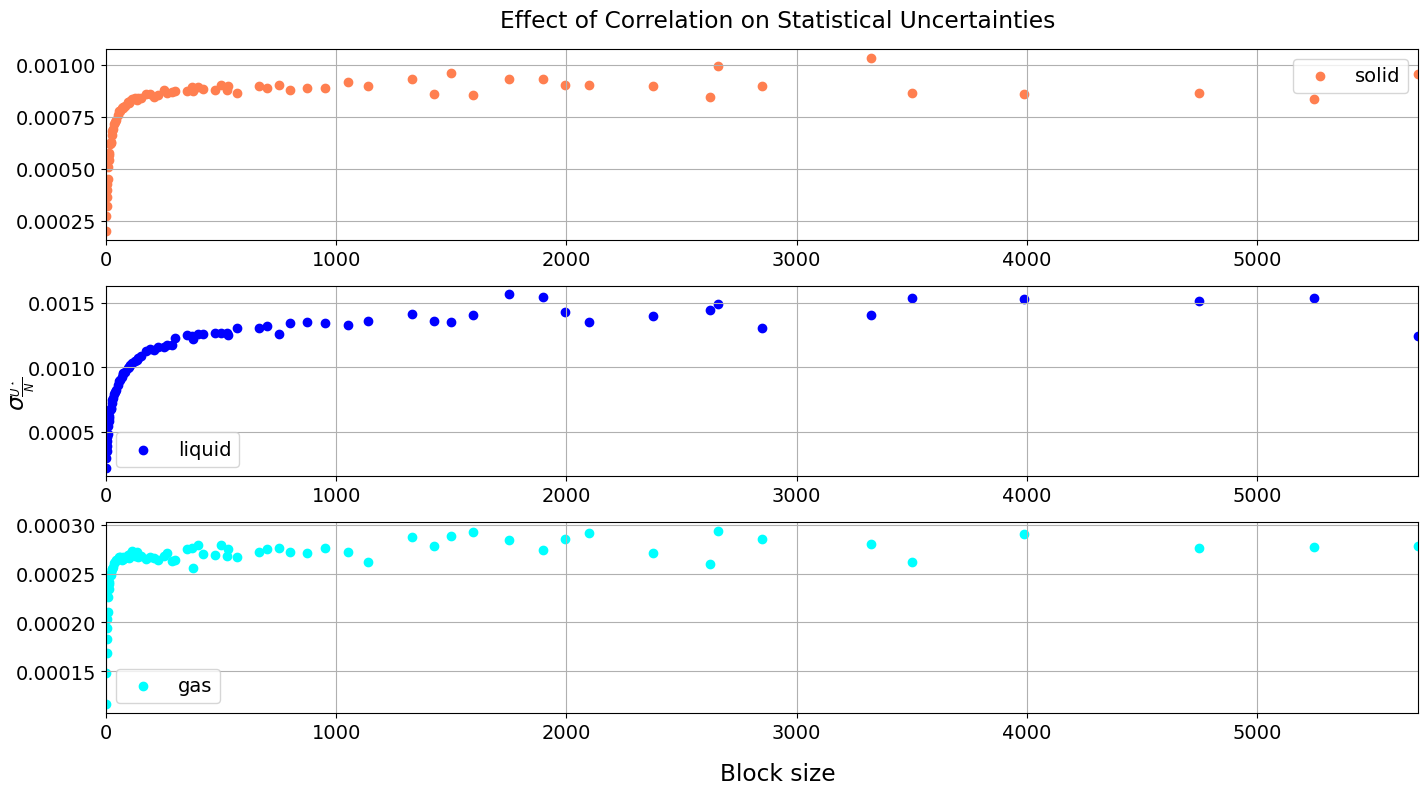

In [189]:
#prepare variables
M = len(thermalized_data["gas"])
L_space = np.array([1, 2, 3, 4, 5, 6, 7, 10, 12, 14, 15, 19, 20, 21, 25, 28, 30, 35, 38, 42, 50, 57, 60, 70, 75, 76, 84, 95, 100, 105, 114, 125, 133, 140, 150, 175, 190, 210, 228, 250, 266, 285, 300, 350, 375, 380, 399, 420, 475, 500, 525, 532, 570, 665, 700, 750, 798, 875, 950, 1050, 1140, 1330, 1425, 1500, 1596, 1750, 1900, 1995, 2100, 2375, 2625, 2660, 2850, 3325, 3500, 3990, 4750, 5250, 5700])
N_space = M // L_space

#function to perform block average
def BlockAverage(Nblocks, L, data):
    blocked_data = [data[i*L:(i+1)*L] for i in range(Nblocks)]
    block_averages =  np.array([sum(block) / len(block) for block in blocked_data])
    average = sum(block_averages)/Nblocks
    aveofsquares = sum(block_averages*block_averages)/Nblocks
    final_sigma = np.sqrt( (aveofsquares - average**2) / (Nblocks-1))
    return average, final_sigma

fig,ax = plt.subplots(3,1,figsize=(16,8))
axs = ax.flatten()
systems = ['solid','liquid','gas']
colors=['coral','blue','cyan']
for i in range(3):
    #select the sigmas
    ProgAve = np.array([BlockAverage(Ns,M//Ns,thermalized_data[systems[i]]) for Ns in N_space])
    axs[i].scatter(L_space,ProgAve[:,1], color=colors[i], label = systems[i])
    axs[i].grid(True)
    axs[i].legend()
    axs[i].set_xbound(0,L_space[-1])
fig.suptitle("Effect of Correlation on Statistical Uncertainties")
fig.supxlabel('Block size')
fig.supylabel(r"$\sigma_\frac{U^\star}{N}$")
plt.subplots_adjust(left=0.08, bottom=0.1, right=0.9, top=0.93, wspace=0.2, hspace=0.24)
plt.show()

We can see that after around $L=500$ a plateau is reached. Before that value, correlation in the steps makes measurement look alike, thus reducing (underestimating) the statistical uncertainty. One should find the length of the blocks such that averages between blocks are statistically independent; when this is the case, the Central Limit Theorem can be applied and this gives the standard formula for block average. Once the CLT is satisfied $\sigma$ does not change anymore.

### <span style="color:olivedrab"> 04.3: Results for Argon </span>

We are now ready to perform the actual simulations. We report the input parameters. Note that the box side lenght is fixed by the phase choice ($\rho$) and the number of particles (108).

| Phase | $\rho^\star$ | $T^\star$ | Box side length | $r_c$ | Nsteps per block | Nblocks | Equilibration steps | Delta Metropolis |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| Solid | 1.1 | 0.8 | 4.613 | 2.2 | 1000 | 50 | 500 | 0.11 |
| Liquid | 0.8 | 1.1 | 5.130 | 2.5 | 1000 | 50 | 500 | 0.2 |
| Gas | 0.05 | 1.2 | 12.927 | 5 | 1000 | 50 | 500 | 6 |

We are interested to measure pressure $P^*$, potential energy $\frac{U^*}{N}$ and the pair distribution function $g(r)$. That is the function that describes how many particles I can find separated by a distance $r$. For our system it can be evaluated as:
$$
g(r) = \frac{1}{\rho \, N \, \Delta V(r)} \langle \sum_{i,j; \, i < j } \delta(r - r_{ij}) \rangle
$$

by building a histogram that counts the couple of particles in $r \in \left[0,\frac{L}{2} \right]$, $L$ being the box side. Normalization $\Delta V(r)=\frac{4}{3} \pi ((r+dr)^3-r^3)$ is due to the usage of spherical coordinates in space. 

In the following we also plot the Lennard-Jones potential to have a grasp on the lenght scales and see how $g(r)$ plummets to zero where the potential is strongly repulsive, namely at the hard core.

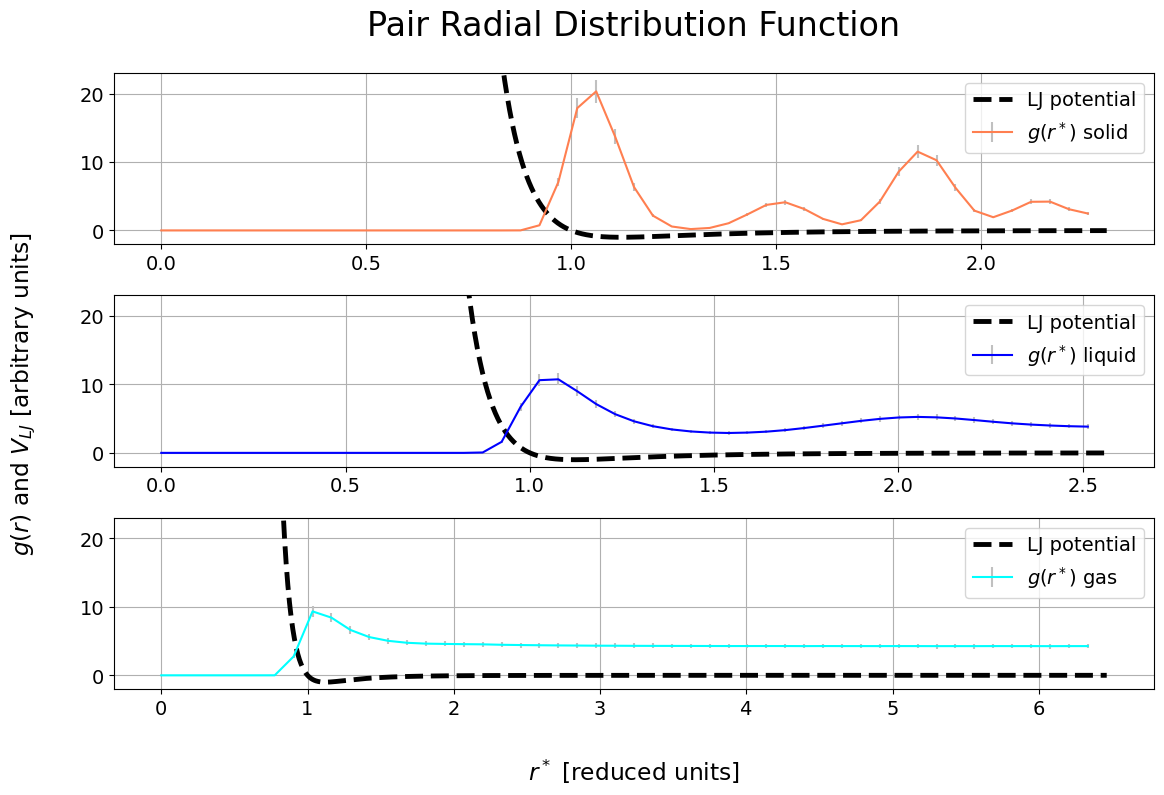

In [169]:
colors=['coral','blue','cyan']
box = [4.613, 5.130, 12.927]
Ncouples = 108*107/2
fig,ax = plt.subplots(3,1,figsize=(13,8))
axs = ax.flatten()
axs[0].grid(True)
axs[1].grid(True)
axs[2].grid(True)
gofr = np.loadtxt("MC_results/solid_simulation/output_gofr.dat")
axs[0].errorbar(gofr[:,0]/50*box[0]/2,gofr[:,1], yerr = gofr[:,2], color=colors[0], ecolor="silver", label= "$g(r^*)$ solid")
gofr = np.loadtxt("MC_results/liquid_simulation/output_gofr.dat")
axs[1].errorbar(gofr[:,0]/50*box[1]/2,gofr[:,1], yerr = gofr[:,2], color=colors[1], ecolor="silver", label= "$g(r^*)$ liquid")
gofr = np.loadtxt("MC_results/gas_simulation/output_gofr.dat")
axs[2].errorbar(gofr[:,0]/50*box[2]/2,gofr[:,1], yerr = gofr[:,2], color=colors[2], ecolor="silver", label= "$g(r^*)$ gas")

def LJpot(r) :
    return  4*(1/r**12 - 1/r**6) 

x = np.linspace(0.82,box[0]/2,num=1000)
axs[0].plot(x, LJpot(x), color="black", linewidth=3.5, linestyle = "dashed", label = "LJ potential")
x = np.linspace(0.83,box[1]/2,num=1000)
axs[1].plot(x, LJpot(x), color="black", linewidth=3.5, linestyle = "dashed",label = "LJ potential")
x = np.linspace(0.82,box[2]/2,num=1000)
axs[2].plot(x, LJpot(x), color="black", linewidth=3.5, linestyle = "dashed",label = "LJ potential")

axs[0].set_ylim(-2,23)
axs[1].set_ylim(-2,23)
axs[2].set_ylim(-2,23)
axs[0].legend()
axs[1].legend()
axs[2].legend()
#ax2 = axs[0].twinx()

fig.supxlabel(r'$r^*$ [reduced units]')
fig.supylabel(r'$g(r)$ and $V_{LJ}$ [arbitrary units]')

fig.suptitle("Pair Radial Distribution Function",fontsize=24)
plt.subplots_adjust(left=0.1, bottom=0.13, right=0.9, top=0.9, wspace=0.3, hspace=0.3)
plt.show()

We can also see different structure in the phases, signaling phase transition! It is remarkable how the solid displays a lookalike of a Shell-structure.

Here we report simulation results for pressure and energy.

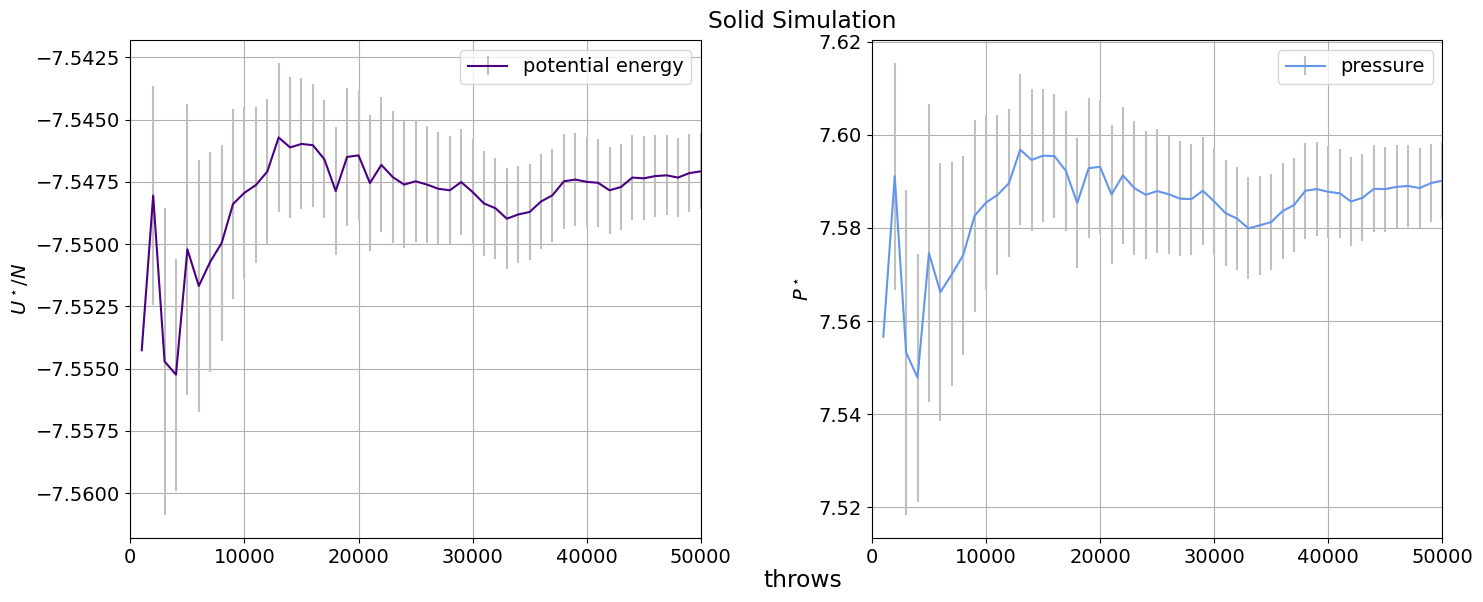

In [167]:
#Solid analysis

#import data formatted as table from a .txt file
data = {
    'potential energy'   : np.loadtxt('MC_results/solid_simulation/output_epot.dat'), 
    'pressure'           : np.loadtxt('MC_results/solid_simulation/output_pres.dat')
}

L=1000                  # Block size

quantities = [ 'potential energy', 'pressure']

ylabels = [ r'$U^\star/N$', r'$P^\star$']

colors = ['indigo','cornflowerblue']

fig,ax = plt.subplots(1,2,figsize=(16,6))
axs = ax.flatten()

#plot 
for i in range(2):
    axs[i].errorbar(data[quantities[i]][:,0]*L,data[quantities[i]][:,2],yerr=
             data[quantities[i]][:,3], color=colors[i], ecolor="silver", label = quantities[i])
    axs[i].grid(True)
    axs[i].legend()
    axs[i].set_xbound(0,len(data[quantities[i]][:,0])*L)
    axs[i].set_ylabel(ylabels[i])
#axs[5].axis('off')
fig.suptitle("Solid Simulation")
fig.supxlabel('throws')
plt.subplots_adjust(left=0.08, bottom=0.1, right=0.9, top=0.93, wspace=0.3, hspace=0.24)
plt.show()

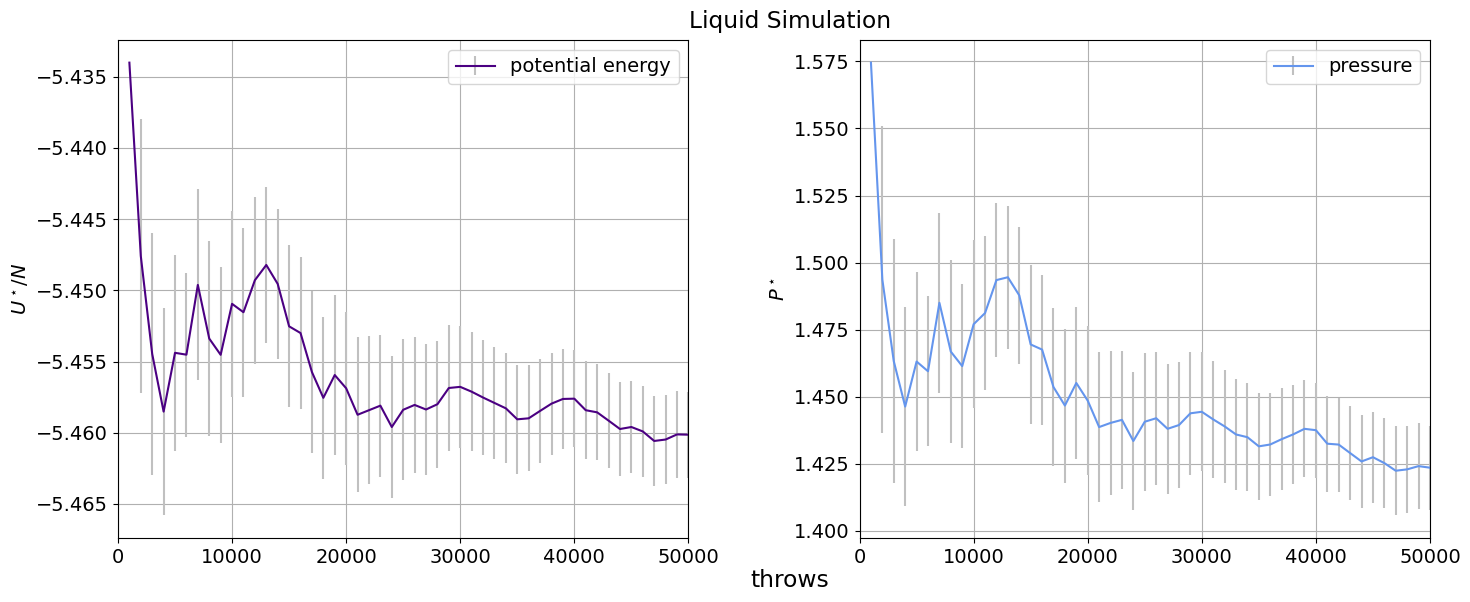

In [165]:
#Liquid analysis

#import data formatted as table from a .txt file
data = {
    'potential energy'   : np.loadtxt('MC_results/liquid_simulation/output_epot.dat'), 
    'pressure'           : np.loadtxt('MC_results/liquid_simulation/output_pres.dat')
}

L=1000                  # Block size

quantities = [ 'potential energy', 'pressure']

ylabels = [ r'$U^\star/N$', r'$P^\star$']

colors = ['indigo','cornflowerblue']

fig,ax = plt.subplots(1,2,figsize=(16,6))
axs = ax.flatten()

#plot 
for i in range(2):
    axs[i].errorbar(data[quantities[i]][:,0]*L,data[quantities[i]][:,2],yerr=
             data[quantities[i]][:,3], color=colors[i], ecolor="silver", label = quantities[i])
    axs[i].grid(True)
    axs[i].legend()
    axs[i].set_xbound(0,len(data[quantities[i]][:,0])*L)
    axs[i].set_ylabel(ylabels[i])
#axs[5].axis('off')
fig.suptitle("Liquid Simulation")
fig.supxlabel('throws')
plt.subplots_adjust(left=0.08, bottom=0.1, right=0.9, top=0.93, wspace=0.3, hspace=0.24)
plt.show()

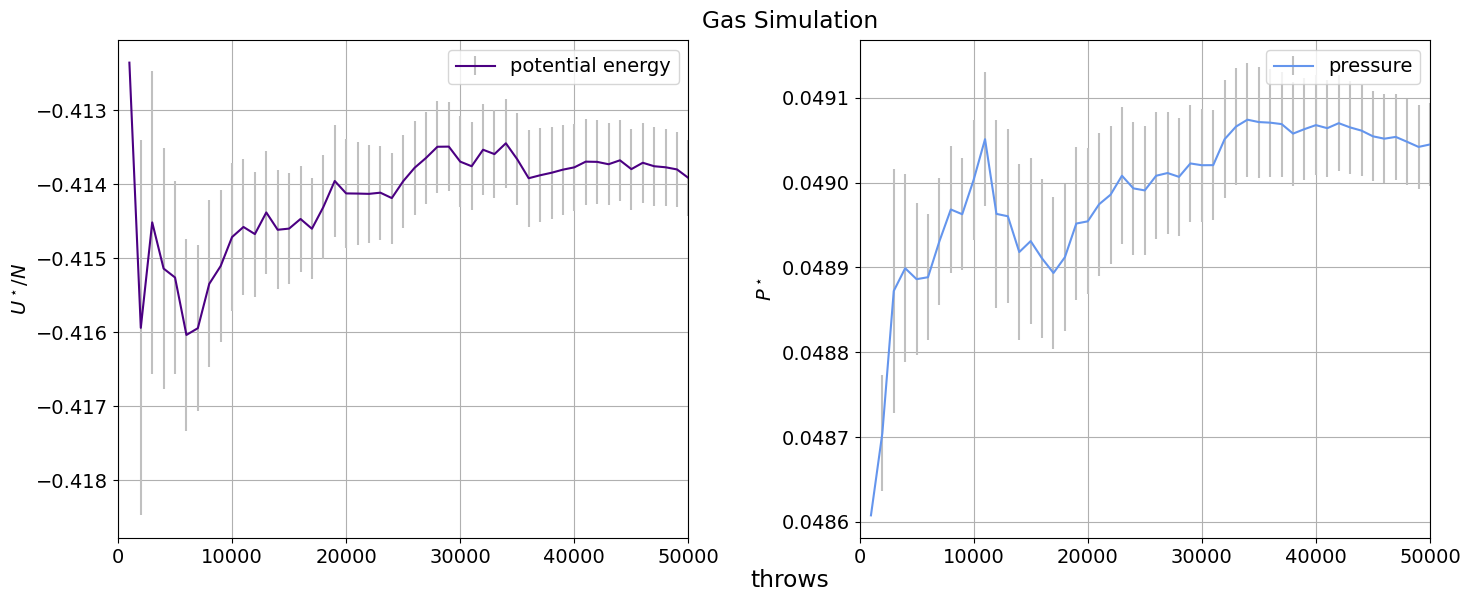

In [166]:
#gas analysis

#import data formatted as table from a .txt file
data = {
    'potential energy'   : np.loadtxt('MC_results/gas_simulation/output_epot.dat'), 
    'pressure'           : np.loadtxt('MC_results/gas_simulation/output_pres.dat')
}

L=1000                  # Block size

quantities = [ 'potential energy', 'pressure']

ylabels = [ r'$U^\star/N$', r'$P^\star$']

colors = ['indigo','cornflowerblue']

fig,ax = plt.subplots(1,2,figsize=(16,6))
axs = ax.flatten()

#plot 
for i in range(2):
    axs[i].errorbar(data[quantities[i]][:,0]*L,data[quantities[i]][:,2],yerr=
             data[quantities[i]][:,3], color=colors[i], ecolor="silver", label = quantities[i])
    axs[i].grid(True)
    axs[i].legend()
    axs[i].set_xbound(0,len(data[quantities[i]][:,0])*L)
    axs[i].set_ylabel(ylabels[i])
#axs[5].axis('off')
fig.suptitle("Gas Simulation")
fig.supxlabel('throws')
plt.subplots_adjust(left=0.08, bottom=0.1, right=0.9, top=0.93, wspace=0.3, hspace=0.24)

### <span style="color:olivedrab"> 04.4: g(r) in Molecular Dynamics Microcanonical Simulation </span>

Finally, we want to measure $g(r)$ with a Molecular Dynamics simulation. We employed the same configurations and nuances from lesson 4.

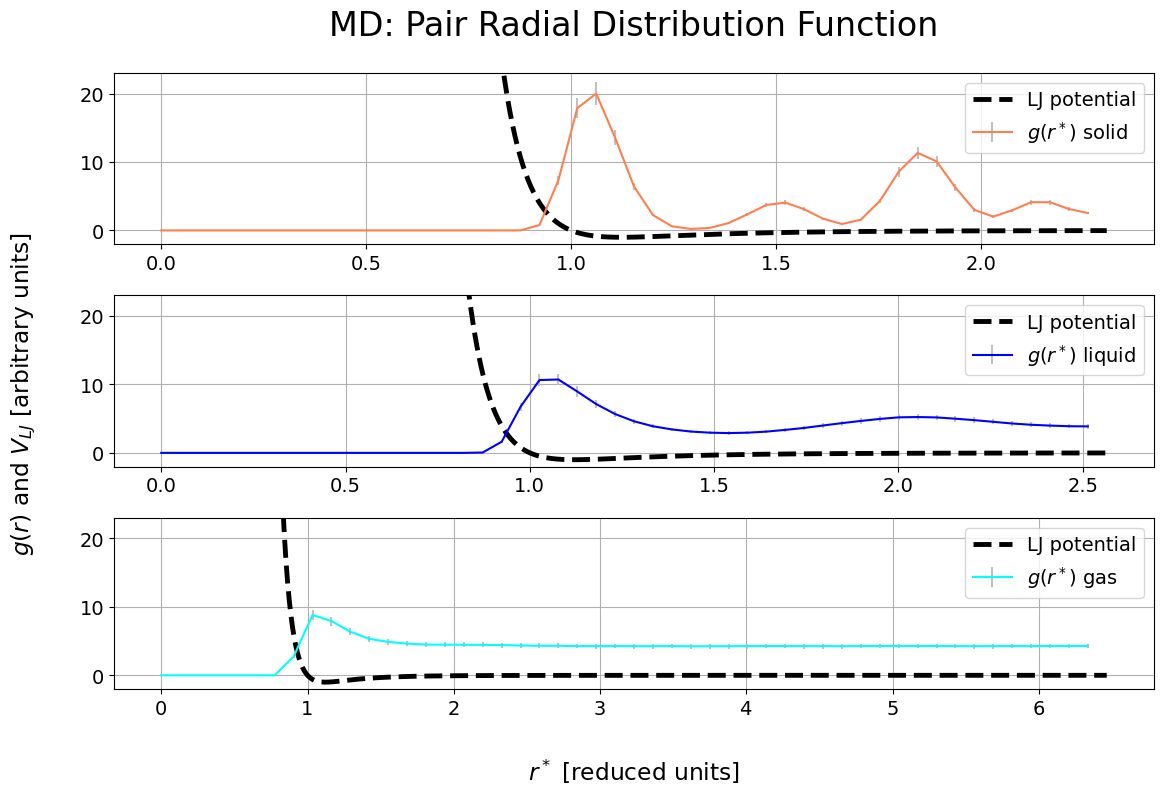

In [190]:
colors=['coral','blue','cyan']
box = [4.613, 5.130, 12.927]
Ncouples = 108*107/2
fig,ax = plt.subplots(3,1,figsize=(13,8))
axs = ax.flatten()
axs[0].grid(True)
axs[1].grid(True)
axs[2].grid(True)
gofr = np.loadtxt("MD/solid_simulation/output_gofr.dat")
axs[0].errorbar(gofr[:,0]/50*box[0]/2,gofr[:,1]/2, yerr = gofr[:,2]/2, color=colors[0], ecolor="silver", label= "$g(r^*)$ solid")
gofr = np.loadtxt("MD/liquid_simulation/output_gofr.dat")
axs[1].errorbar(gofr[:,0]/50*box[1]/2,gofr[:,1]/3, yerr = gofr[:,2]/3, color=colors[1], ecolor="silver", label= "$g(r^*)$ liquid")
gofr = np.loadtxt("MD/gas_simulation/output_gofr.dat")
axs[2].errorbar(gofr[:,0]/50*box[2]/2,gofr[:,1]/15, yerr = gofr[:,2]/15, color=colors[2], ecolor="silver", label= "$g(r^*)$ gas")

def LJpot(r) :
    return  4*(1/r**12 - 1/r**6) 

x = np.linspace(0.72,box[0]/2,num=1000)
axs[0].plot(x, LJpot(x), color="black", linewidth=3.5, linestyle = "dashed", label = "LJ potential")
x = np.linspace(0.73,box[1]/2,num=1000)
axs[1].plot(x, LJpot(x), color="black", linewidth=3.5, linestyle = "dashed",label = "LJ potential")
x = np.linspace(0.72,box[2]/2,num=1000)
axs[2].plot(x, LJpot(x), color="black", linewidth=3.5, linestyle = "dashed",label = "LJ potential")

axs[0].set_ylim(-2,23)
axs[1].set_ylim(-2,23)
axs[2].set_ylim(-2,23)
axs[0].legend()
axs[1].legend()
axs[2].legend()
#ax2 = axs[0].twinx()

fig.supxlabel(r'$r^*$ [reduced units]')
fig.supylabel(r'$g(r)$ and $V_{LJ}$ [arbitrary units]')

fig.suptitle("MD: Pair Radial Distribution Function",fontsize=24)
plt.subplots_adjust(left=0.1, bottom=0.13, right=0.9, top=0.9, wspace=0.3, hspace=0.3)
plt.show()

The results are in optimal agreement between the methods, but we should address that computational time was far extended for the MD simulation, especially for the gaseous phase.